<a href="https://colab.research.google.com/github/Sandwhaletree/Mai_Finlab/blob/main/C3_%E6%88%90%E7%82%BA%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90%E5%B8%AB%E7%9A%84%E7%AC%AC%E4%B8%80%E6%8A%8A%E9%91%B0%E5%8C%99/23'10_26%E6%A8%A1%E6%93%AC%E5%AE%A2%E6%9C%8D%E6%96%87%E5%AD%97%E8%B3%87%E6%96%99_GOOGLE%E8%A9%95%E8%AB%96%E8%B3%87%E6%96%99%E6%8E%A2%E7%B4%A22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **GOOGLE評論資料探索2**

In [1]:
import re
import pandas as pd
import jieba
from wordcloud import WordCloud
# conda install -c https://conda.anaconda.org/conda-forge wordcloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# '資料探索(exploratory data analysis)'
# '資料觀察>>資料是否錯誤>>哪些資訊對公司有用>>鎖定分析方向'

# '1. 資料觀察>>鎖定分析方向(預想)'
#確保目前的路徑
import os
os.chdir('/content/drive/MyDrive/python實作_線上課程/客服文字')

data = pd.read_csv('./gmap評論.csv', encoding='big5',header=0)
data.info()
#'賺錢 >> 節省員工閱讀時間 >> 快速了解大家在說甚麼'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   store     953 non-null    object
 1   username  953 non-null    object
 2   time      953 non-null    object
 3   comment   953 non-null    object
 4   rate      953 non-null    int64 
 5   like      953 non-null    int64 
 6   picture   953 non-null    object
dtypes: int64(2), object(5)
memory usage: 52.2+ KB


In [3]:
#'2. 資料清洗 - 剔除無意義字詞'
jieba.load_userdict('./繁+簡斷詞.txt') #斷詞字典
data['comment'] = data['comment'].astype(str) # int不能decode轉 string
data['comment'] = data['comment'].str.replace(r'[^\w\s]','', regex=True)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.884 seconds.
DEBUG:jieba:Loading model cost 0.884 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [4]:
with open('./stopword.txt', encoding='utf8') as f:
    stop_words = f.read().splitlines()
data['content_cut'] = data['comment'].apply(lambda x : [i for i in jieba.cut(x, cut_all=False) if i not in stop_words])
data['comment'].head(5)
data['content_cut'].head(5)

0    [來此, 消費, 請務必, 請, 同行, 一個, 清醒, 下去, 結帳, 大夜, 收款人, ...
1    [海, 薛, 客人, 一筆, 樣子, 墾, 丁, 滷, 味, 耶, \n, 東區, 不差, ...
2             [終於, 解封, \n, 錢, 櫃大唱, \n, 麥克風, 音質, 超棒, ㄉ]
3    [東西, 好吃, 需要, 一點, 時, 間, 製, 作, \n, 整體, 說, 不貴, 便宜...
4    [包廂, 抽煙, 一到, 樓層, 不用, 進包廂, 聞, 煙味, 服務人員, 說, 有人, ...
Name: content_cut, dtype: object

In [6]:
#'3. 哪些資訊對公司有用? 視覺化觀察'
# 我 愛 睡覺
# 你 愛 跑步
# 愛: TF = 1/3，IDF = 2/2
corpus = [" ".join(review) for review in data['content_cut']]
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf = tfidf.toarray()
tfidf = pd.DataFrame(tfidf, columns=tfidf_vectorizer.get_feature_names_out())
tfidf.T.sum(axis=1) #每個詞的tf-idf總和

00      0.165858
0000    0.203396
0010    0.246115
0030    0.246115
0035    0.246115
          ...   
點餐式     0.258769
點餐點     0.340121
鼻子      0.445353
齊來      0.142057
齊近      0.153186
Length: 2386, dtype: float64

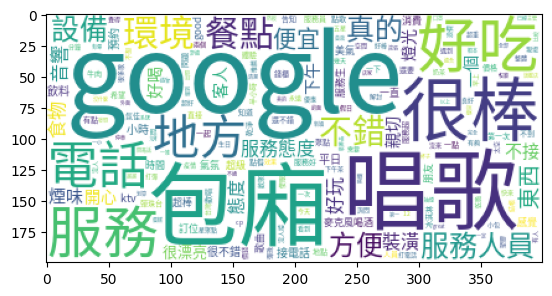

In [9]:
font = './SourceHanSansTWRegular.otf'
my_wordcloud = WordCloud(background_color='white',
                         max_words=500,
                         font_path = font).generate_from_frequencies(tfidf.T.sum(axis=1))
plt.imshow(my_wordcloud)

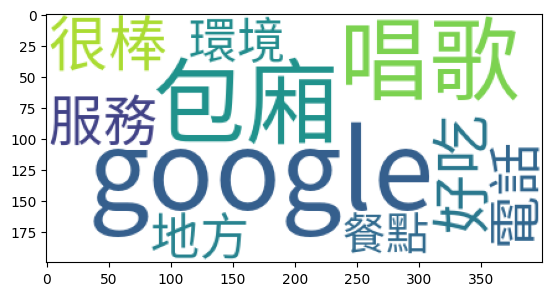

In [10]:
font = './SourceHanSansTWRegular.otf'
my_wordcloud = WordCloud(background_color='white',
                         max_words=10,
                         font_path = font).generate_from_frequencies(tfidf.T.sum(axis=1))
plt.imshow(my_wordcloud)

In [ ]:
# '4. 由圖鎖定分析方向(實際)>>產出初步結論'
# 關鍵字為包廂、服務等

# 文字資料分析方向:
# 1. 大家討論的主題是甚麼
# 2. 風向者偵測
# 3. 情緒分數計算

### **GOOGLE評論資料探索3**

In [11]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [13]:
import os
os.chdir('/content/drive/MyDrive/python實作_線上課程/客服文字')
data = pd.read_csv('./gmap評論.csv', encoding='big5',header=0)

jieba.load_userdict("./繁+簡斷詞.txt") #斷詞字典
data['comment'] = data['comment'].astype(str) # int不能decode轉 string
data['comment'] = data['comment'].str.replace(r'[^\w\s]','', regex=True)

In [15]:
with open('./stopword.txt', encoding='utf8') as f:
    stop_words = f.read().splitlines()
data['content_cut'] = data['comment'].apply(lambda x : [i for i in jieba.cut(x, cut_all=False) if i not in stop_words])

In [16]:
#'風向者(獲得多人認同)偵測 - 誰一直在罵公司?'
df = data.groupby(["username"])['comment'].count().reset_index()
df2 = data.groupby(["username"])['rate'].mean().reset_index()
df3 = data.groupby(["username"])['like'].sum().reset_index()
final = pd.merge(df, df2, on="username",how='inner')
final = pd.merge(final, df3, on="username",how='inner')
kol = final.sort_values(by = 'like',ascending=False) #False
kol = kol.iloc[:5,:]

In [18]:
#'主題挖掘-深入了解大家在說啥'
data['content_cut'] = data['content_cut'].astype(str)
cv = CountVectorizer(min_df =1, stop_words = stop_words)
s_matrix = cv.fit_transform(data['content_cut'])
featureNames = cv.get_feature_names_out()
LDA = LatentDirichletAllocation(n_components = 3, random_state=42)
lda = LDA.fit(s_matrix) # 建模

In [19]:
#三大主題
for idx, topic in enumerate(lda.components_):
        print ("Topic ", idx, " ".join(featureNames[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 包廂 唱歌 服務 時間 感覺 音響 好吃 不錯 真的 設備
Topic  1 包廂 電話 服務人員 真的 預約 餐點 一直 態度 告知 不接
Topic  2 好吃 唱歌 很棒 包廂 環境 餐點 服務人員 地方 一個 親切
